In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import folium
from tqdm import tqdm
import concurrent
import time
import threading


In [2]:
print("[INFO] Reading dataset")
ds = xr.open_dataset('../gribs/vento_nordeste.grib', engine="cfgrib")
ds


[INFO] Reading dataset


<xarray.Dataset>
Dimensions:     (time: 8784, latitude: 5, longitude: 5)
Coordinates:
    number      int32 ...
  * time        (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -24.0 -24.25 -24.5 -24.75 -25.0
  * longitude   (longitude) float64 -45.0 -44.75 -44.5 -44.25 -44.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    u10         (time, latitude, longitude) float32 ...
    v10         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-02T12:39 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
lat = -24.4
lon = -43.1
u10_all = ds.u10.sel(latitude=lat, longitude=lon, method="nearest")
v10_all = ds.v10.sel(latitude=lat, longitude=lon, method="nearest")
u10_all

<xarray.DataArray 'u10' (time: 8784)>
[8784 values with dtype=float32]
Coordinates:
    number      int32 ...
  * time        (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    float64 -24.5
    longitude   float64 -44.0
    valid_time  (time) datetime64[ns] ...
Attributes: (12/31)
    GRIB_paramId:                             165
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      25
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           10u
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                10 metre U wind component
    units:                                    m s**-1
    standard_name:                            unknown

In [4]:
current_time = pd.Timestamp("2020-01-01 00:00:00")
u10 = np.zeros(8784)
v10 = np.zeros(8784)

for i in tqdm(range(8784)):
    u10[i] = u10_all.sel(time=current_time, method='nearest').values
    v10[i] = v10_all.sel(time=current_time, method='nearest').values
            
    current_time += pd.Timedelta(hours=1)


100%|██████████| 8784/8784 [03:46<00:00, 38.84it/s]


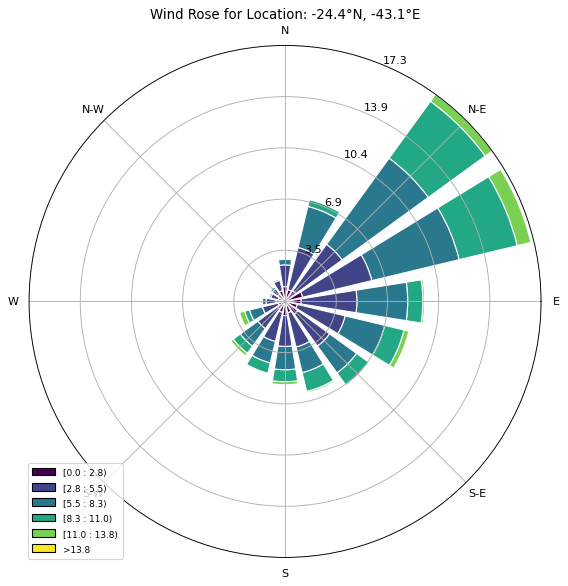

In [5]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes

# Calculate wind speed and direction from u10 and v10 components
wind_speed = np.sqrt(u10**2 + v10**2)  # Wind speed magnitude
wind_direction = np.degrees(np.arctan2(-u10, -v10)) % 360  # Wind direction (meteorological convention)

# Create windrose plot
ax = WindroseAxes.from_ax()
ax.bar(wind_direction, wind_speed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title(f'Wind Rose for Location: {lat}°N, {lon}°E')
plt.show()

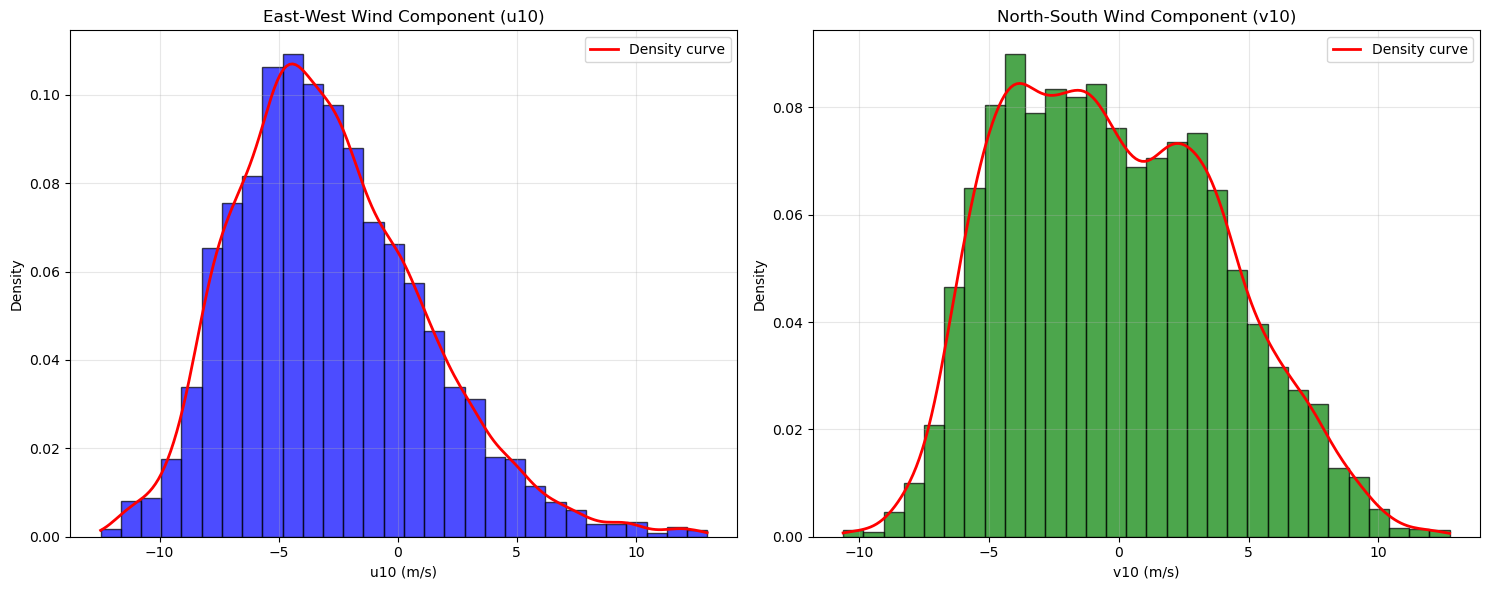

In [10]:
# Density plots for smoother distribution visualization
from scipy.stats import gaussian_kde

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# U10 histogram with density
ax1.hist(u10, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
u10_density = gaussian_kde(u10)
u10_xs = np.linspace(u10.min(), u10.max(), 200)
ax1.plot(u10_xs, u10_density(u10_xs), 'r-', linewidth=2, label='Density curve')
ax1.set_xlabel('u10 (m/s)')
ax1.set_ylabel('Density')
ax1.set_title('East-West Wind Component (u10)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# V10 histogram with density  
ax2.hist(v10, bins=30, density=True, alpha=0.7, color='green', edgecolor='black')
v10_density = gaussian_kde(v10)
v10_xs = np.linspace(v10.min(), v10.max(), 200)
ax2.plot(v10_xs, v10_density(v10_xs), 'r-', linewidth=2, label='Density curve')
ax2.set_xlabel('v10 (m/s)')
ax2.set_ylabel('Density')
ax2.set_title('North-South Wind Component (v10)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()